In [1]:
import os.path

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn

from core.audio_handler import AudioHandler
from core.data_mediator import DataMediator
from core.sound_classifier import SoundClassifier

In [2]:
speech_path = os.path.abspath('../datasets/speech')
sounds_path = os.path.abspath('../datasets/sounds')
noises_path = os.path.abspath('../datasets/noises')

positive_paths = [speech_path]
negative_paths = [sounds_path, noises_path]

audio_handler = AudioHandler(target_spectrogram_shape=(64, 128))
data_mediator = DataMediator(audio_handler=audio_handler)
data_loaders = data_mediator.create_data_loaders(positive_paths, 'mp3', 500, negative_paths, 'wav', 500)
train_loader, val_loader, test_loader = data_loaders

print('Finished Data Preparation')

Data import started
Processed 500 positive spectrograms with background sounds
Processed 500 negative spectrograms
Dataloaders imported
Finished Data Preparation


In [3]:
model = SoundClassifier(64 * 128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print('Model initialized')

Model initialized


In [4]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(
        f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

print('Finished Training')

Epoch 1, Training Loss: 1.6002, Validation Loss: 0.2759, Accuracy: 91.33%
Epoch 2, Training Loss: 0.2472, Validation Loss: 0.2798, Accuracy: 93.33%
Epoch 3, Training Loss: 0.1862, Validation Loss: 0.2499, Accuracy: 94.67%
Epoch 4, Training Loss: 0.1547, Validation Loss: 0.2249, Accuracy: 94.00%
Epoch 5, Training Loss: 0.1418, Validation Loss: 0.2270, Accuracy: 94.67%
Epoch 6, Training Loss: 0.1224, Validation Loss: 0.2249, Accuracy: 94.00%
Epoch 7, Training Loss: 0.1042, Validation Loss: 0.2080, Accuracy: 94.00%
Epoch 8, Training Loss: 0.0809, Validation Loss: 0.2233, Accuracy: 94.67%
Epoch 9, Training Loss: 0.0765, Validation Loss: 0.2285, Accuracy: 94.00%
Epoch 10, Training Loss: 0.0605, Validation Loss: 0.1852, Accuracy: 94.67%
Epoch 11, Training Loss: 0.0540, Validation Loss: 0.2189, Accuracy: 94.00%
Epoch 12, Training Loss: 0.0447, Validation Loss: 0.2000, Accuracy: 93.33%
Epoch 13, Training Loss: 0.0362, Validation Loss: 0.2020, Accuracy: 93.33%
Epoch 14, Training Loss: 0.0317, V

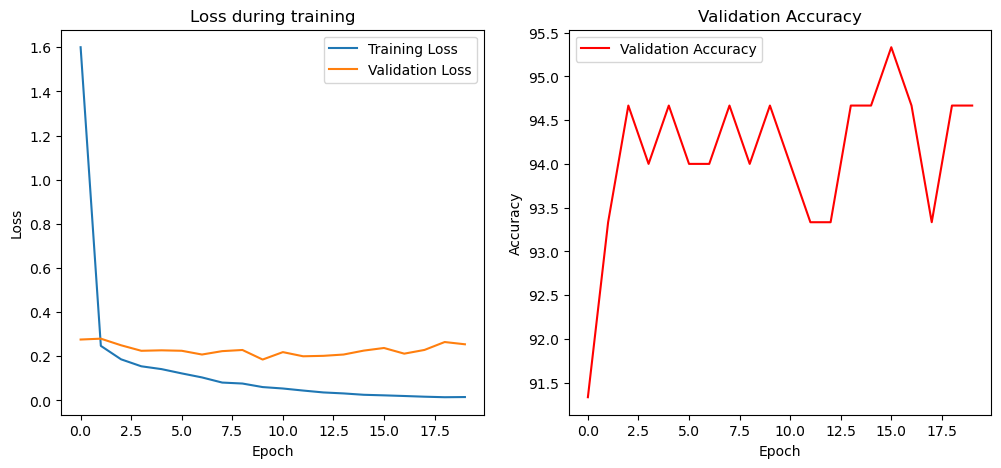

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test files: {100 * correct // total} %')

Accuracy of the network on test files: 97 %
